# Notebook to look at options for using Kinefly-like methods to extract wing kinematics

Until now, I've been trying stuff more like what I did in the Cohen Lab (binarization, segmentation, etc),
but am now curious about using the user ROIs + edge detection or something

## Import

In [4]:
%load_ext autoreload
%autoreload 2
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
import cv2

import skimage.morphology  as morphology

from scipy.signal import find_peaks, medfilt
from scipy.interpolate import interp1d

from skimage.color import label2rgb, rgb2gray
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity
from skimage.feature import canny, peak_local_max
from skimage.filters import threshold_otsu, gaussian, threshold_multiotsu, sobel
from skimage.filters.rank import gradient, enhance_contrast, median
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border, flood, flood_fill, watershed
from skimage.transform import hough_line, hough_line_peaks
from skimage.util import invert, img_as_float, img_as_ubyte, img_as_uint, compare_images, img_as_float64

from mosquito.fly_tracking_frame import FlyFrame, get_angle_from_points
from mosquito.get_wing_kinematics import load_video_data, get_highspeed_frame_fg, get_wing_imgs, track_low_speed_video, ArrayVideoCapture
from mosquito.process_abf import load_processed_data, estimate_spike_rate
from mosquito.util import idx_by_thresh

## Params

In [6]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels


## Helper functions

In [7]:
def get_wing_edges(im, mask, hinge_pt, canny_sigma=3.0, min_area=10):
    """
    Function to extract edges from an image of the wings
    """
    # convert from RGB as needed
    if len(im.shape) > 2:
        im = rgb2gray(im)

    # get edge image (masked)
    edges = canny(im, sigma=canny_sigma)
    edges *= mask

    # find edges as connected components
    props = regionprops(label(edges))
    props = [p for p in props if p.area > min_area]
    
    # get angles of each connected component relative to hinge point
    edge_angles = list()
    for p in props:
        # centroid of current component
        cm = p.centroid

        # note that we need to switch order of centroid coordinates
        edge_angles.append(get_angle_from_points(hinge_pt, np.array([cm[1], cm[0]])))

    # pull out max and min angles
    if len(edge_angles) == 0:
        max_angle = None
        min_angle = None
        
        print('No edges detected')
        
    elif len(edge_angles) == 1:
        max_angle = edge_angles[0]
        min_angle = None

    else:
        max_angle = max(edge_angles)
        min_angle = min(edge_angles)
        
    return max_angle, min_angle
    

In [8]:
def get_wing_edges_roi(im_clip, mask_clip, hinge_pt, roi, canny_sigma=3.0, min_area=10, extra_process_flag=True):
    """
    Function to extract edges from an image of the wings *IN ROI REGION*
    """
    # scale image intensity? particularly helpful with lowspeed video
    if extra_process_flag:
        im_clip = rescale_intensity(im_clip*morphology.isotropic_dilation(mask_clip, 2))
        # im_clip = img_as_ubyte(im_clip)
        
    # get edge image (masked)
    edges = canny(im_clip, sigma=canny_sigma)
    edges *= mask_clip
    edges = morphology.isotropic_closing(edges, 3)
    
    # find edges as connected components
    props = regionprops(label(edges))
    props = [p for p in props if p.area > min_area]
    
    # get angles of each connected component relative to hinge point
    edge_angles = list()
    for p in props:
        # centroid of current component
        cm = p.centroid

        # note that we need to switch order of centroid coordinates
        edge_angles.append(get_angle_from_points(hinge_pt, np.array([cm[1] + roi[0], cm[0] + roi[1]])))

    # pull out max and min angles
    if len(edge_angles) == 0:
        max_angle = None
        min_angle = None
        
        print('No edges detected')
        
    elif len(edge_angles) == 1:
        max_angle = edge_angles[0]
        min_angle = None

    else:
        max_angle = max(edge_angles)
        min_angle = min(edge_angles)
        
    return max_angle, min_angle
    

In [9]:
# -----------------------------------------------------------------------------
# callback function to return x,y coordinates of a mouse DOUBLE LEFT CLICK 
def get_xy(event, x, y, flags, param):
    global mouseX, mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print((x, y))
        mouseX, mouseY = x, y
        
# -----------------------------------------------------------------------------
# get capillary tip manually        
def get_cap_tip(img):
    clone = img.copy()
    win_name = 'get capillary tip (double click, enter when finished)'
    cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(win_name, get_xy)
    cv2.imshow(win_name, img)

    while True:
        cv2.imshow(win_name, img)
        try:
            img = clone.copy()
            cv2.circle(img, (mouseX, mouseY), 4, (255, 0, 0), -1)
        except NameError:
            pass

        k = cv2.waitKey(1) & 0xFF
        if k == 13:
            break

    img = clone.copy()
    cv2.destroyAllWindows()

    return (mouseX, mouseY)



In [10]:
def cart2pol(x):
    """
    Convenience function for cartesian to polar coordinates
    """
    rho = np.linalg.norm(x)
    phi = np.arctan2(x[1], x[0])
    return rho, phi
    

In [11]:
def get_wedge_mask(img_shape, angle_hi, angle_lo, hinge_pt, radius_inner, radius_outer, viz_flag=False):
    """
    Grab a wedge-of-annulus section of a rectangular image

    Basically the same as get_mask in fly_tracking_frame.py, MyWedge
    
    """
    # initialize mask
    mask = np.zeros(img_shape, dtype=np.uint8)

    # draw white and black ellipse segments to make mask
    cv2.ellipse(mask, hinge_pt, (radius_outer, radius_outer), 0, angle_hi, angle_lo, (255, 255, 255, 255),-1)
    cv2.ellipse(mask, hinge_pt, (radius_inner, radius_inner), 0, 0, 360, (0, 0, 0, 255), -1)

    # Make the mask one pixel bigger to account for pixel aliasing.
    mask = cv2.dilate(mask, np.ones([3, 3]))

    # get indices for mask values
    x_ind, y_ind = np.where(mask > 0)

    if viz_flag:
        fig, ax = plt.subplots()
        ax.imshow(mask)
        ax.set_axis_off()
        
    # return 
    return x_ind, y_ind, (mask > 0)
    

In [12]:
def get_wing_edges_wedge_sum(img, wedge_masks, angles, min_prominence=0.001):
    """
    Convenience function to detect wing edge by summing pixel intensity in small angle wedge segments
    
    """
    # do summation of each wedge
    wedge_sums = []
    for mask in wedge_masks:
        # do normalized sum
        wedge_sum = np.sum(img*mask)/np.sum(mask)
        wedge_sums.append(wedge_sum)

    # detect edges in this "1D image"
    edge_1d = sobel(np.atleast_2d(wedge_sums))
    edge_1d = edge_1d.ravel()

    # find peaks in the edge detection
    pks, _ = find_peaks(edge_1d, prominence=(min_prominence, None))

    # convert peak locations to angles and return max + min
    edge_angles = angles[pks]

     # pull out max and min angles
    if len(edge_angles) == 0:
        max_angle = None
        min_angle = None
        
        print('No edges detected')
        
    elif len(edge_angles) == 1:
        max_angle = edge_angles[0]
        min_angle = None

    else:
        max_angle = np.max(edge_angles)
        min_angle = np.min(edge_angles)

    return max_angle, min_angle
    

## Load data

In [13]:
# info for file to load
data_folder = 50  #  48 # 46
axo_num = 27
frame_range = (0, 1000)
return_cap_flag = False
wing_side = 'right'

imgs, _ = load_video_data(data_folder, axo_num, frame_range=frame_range, return_cap_flag=return_cap_flag)


In [14]:
# make instance of fly frame class
fly_frame = FlyFrame()


## Get fly reference frame

In [15]:
# draw on reference frame
cap = ArrayVideoCapture(imgs.copy())
fly_frame.run_video(cap)
cap.release()


In [16]:
# get params for drawn on ref frame
params = fly_frame.params

# get masks
mask = getattr(fly_frame, f'{wing_side}_wing').mask
mask = (mask > 0)

# get hinge point
hinge_pt = fly_frame.params[f'{wing_side}_wing']['hinge_pt']

# get roi
roi = getattr(fly_frame, f'{wing_side}_wing').roi

# get radii of ROI
radius_inner = params[f'{wing_side}_wing']['radius_inner']
radius_outer = params[f'{wing_side}_wing']['radius_outer']
radius_avg = (radius_inner + radius_outer)/2.0

## Run test of full tracking function

In [17]:
# run test
from mosquito.get_wing_kinematics import track_low_speed_video, run_track_low_speed_video, add_kinematics_to_axo

# wing_data = track_low_speed_video(imgs, fly_frame=fly_frame, viz_flag=False)
wing_data = run_track_low_speed_video(data_folder, axo_num, fly_frame=fly_frame, verbose_flag=True, viz_flag=True)
data = add_kinematics_to_axo(wing_data, data_folder, axo_num, data_suffix='_spikes', save_flag=True)

Completed processing frames 0 through 1000
Completed processing frames 1000 through 2000
Completed processing frames 2000 through 3000
Completed processing frames 3000 through 4000
Completed processing frames 4000 through 5000
Completed processing frames 5000 through 6000
Completed processing frames 6000 through 7000
Completed processing frames 7000 through 8000
Completed processing frames 8000 through 9000
Completed processing frames 9000 through 10000
Completed processing frames 10000 through 11000
Completed processing frames 11000 through 12000
Completed processing frames 12000 through 13000
Completed processing frames 13000 through 13973


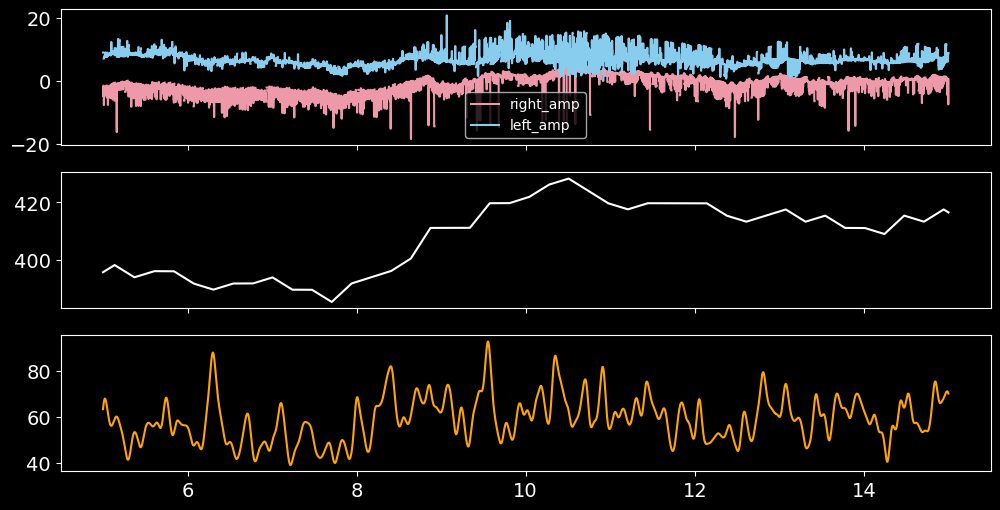

In [18]:
# plot output
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12,6), sharex=True)
med_kernel = 11

# estimate spike rate
spike_rate = estimate_spike_rate(data['good_spike_idx'], data['sampling_freq'], data['time'].size)
t = data['time']
wbf = data['wbf']

# right_amp = np.rad2deg(wing_data['right']['angles_min'])
right_amp = np.rad2deg(data['right_amp'])
right_amp_filt = medfilt(right_amp, kernel_size=med_kernel)

# left_amp = np.rad2deg(wing_data['left']['angles_max'])
left_amp = np.rad2deg(data['left_amp'])
left_amp_filt = medfilt(left_amp, kernel_size=med_kernel)
left_amp_filt[left_amp_filt < 0] = np.nan

# region to plot 
tmin = 5
tmax = 15
mask = (t >= tmin) & (t <= tmax)

# ax.plot(np.rad2deg(wing_data['right']['angles_max']), 'r-')
ax0.plot(t[mask], right_amp_filt[mask], '-', color='#EE99AA', label='right_amp')
ax0.plot(t[mask], left_amp_filt[mask], '-', color='#88CCEE', label='left_amp')
ax0.legend()

ax1.plot(t[mask], wbf[mask], 'w-', label='wbf')

ax2.plot(t[mask], spike_rate[mask], color='orange')
# ax.plot(wing_data['left']['angles_min'], 'b--')

# ax2.set_xlim([0, 20])

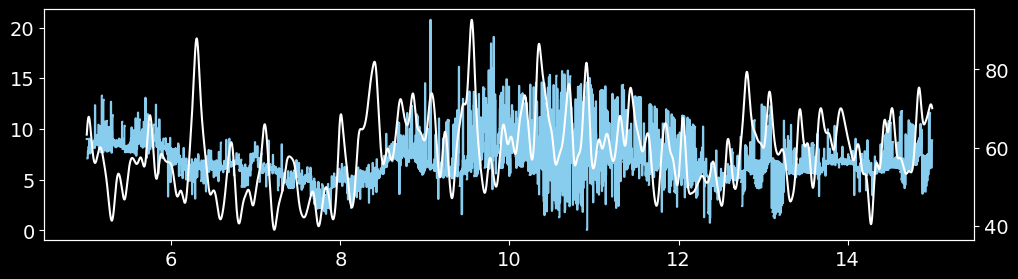

In [19]:
# plot together 
fig, ax = plt.subplots(figsize=(12,3))

# region to plot 
tmin = 5
tmax = 15
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], left_amp_filt[mask], '-', color='#88CCEE')
ax_twin = ax.twinx()
ax_twin.plot(t[mask], spike_rate[mask], '-', color='w')


In [28]:
test = imgs[:,:,:, 0]
np.sum(test, axis=(1,2)).shape

(1000,)

In [117]:
# load accompanying data set to sync
data = load_processed_data(data_folder, axo_num, data_suffix='_spikes')


dict_keys(['sampling_freq', 'filepath', 'units', 'header', 'time', 'emg', 'cam', 'mic', 'odor', 'species', 'muscle_type', 'filename', 'mic_filt', 'mic_phase', 'wbf_mean', 'wbf', 'flying_idx', 'emg_filt', 'spikes', 'spike_t', 'spike_idx', 'spike_rate', 'params', 'good_spikes', 'good_spike_idx'])

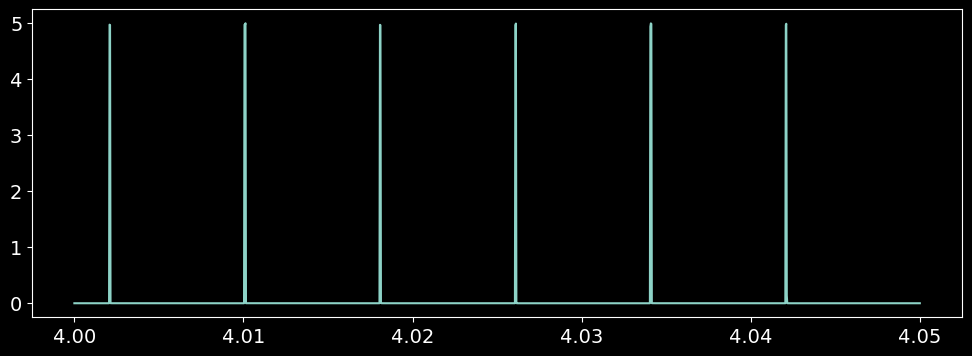

In [191]:
# read camera signal
t = data['time']
cam = data['cam']

tmin = 4
tmax = 4.05
mask = (t >= tmin) & (t <= tmax)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t[mask], cam[mask])

In [131]:
# find where camera signal is high
cam_high_idx = idx_by_thresh(cam)
cam_high_idx = [idx[0] for idx in cam_high_idx]

# and use this to get effective framerate (are we getting per frame measurements?)
cam_high_t = np.asarray([t[idx] for idx in cam_high_idx])
print(np.mean(np.diff(cam_high_t))**(-1))

124.99744848627554


In [139]:
# camera signal is only at 1/2 fps, so need to fill it out
cam_high_idx = np.asarray(cam_high_idx)
cam_high_idx_mid = (cam_high_idx[1:] + cam_high_idx[:-1])/2
cam_high_idx_full = np.sort(np.concatenate((cam_high_idx, cam_high_idx_mid))).astype('int')

print(cam_high_idx.shape)
print(cam_high_idx_full.shape)

(7112,)
(14223,)


In [192]:
import pickle
test = wing_data.copy()
test['fly_frame'] = fly_frame.__dict__
pickle.dump(test, open('test_nested_dict.pkl', "wb"))

nested_test = pickle.load(open('test_nested_dict.pkl', "rb"))
nested_test['fly_frame']

{'name': 'fly frame',
 'params': {'body_axis': {'start_pt': array([318, 332]),
   'end_pt': array([194, 334])},
  'line_test': {'start_pt': array([ 80, 230]), 'end_pt': array([332, 506])},
  'left_wing': {'hinge_pt': array([324, 363]),
   'radius_inner': 80.00000000000013,
   'radius_outer': 147.05441169852773,
   'angle_hi': 2.0134889197067616,
   'angle_lo': 1.2597980461893554},
  'right_wing': {'hinge_pt': array([327, 304]),
   'radius_inner': 96.99326916178632,
   'radius_outer': 177.68511473952995,
   'angle_hi': -1.1962493546992328,
   'angle_lo': -1.7748143063874453}},
 'body_axis': <mosquito.fly_tracking_frame.MyLine at 0x739c80a26960>,
 'right_wing': <mosquito.fly_tracking_frame.MyWedge at 0x739c808bb140>,
 'left_wing': <mosquito.fly_tracking_frame.MyWedge at 0x739c808b8410>,
 'partnames': ['body_axis', 'right_wing', 'left_wing'],
 'mousing': False,
 'current_tag': None,
 'current_partname': None,
 'current_part': None,
 'image_shape': (640, 640)}

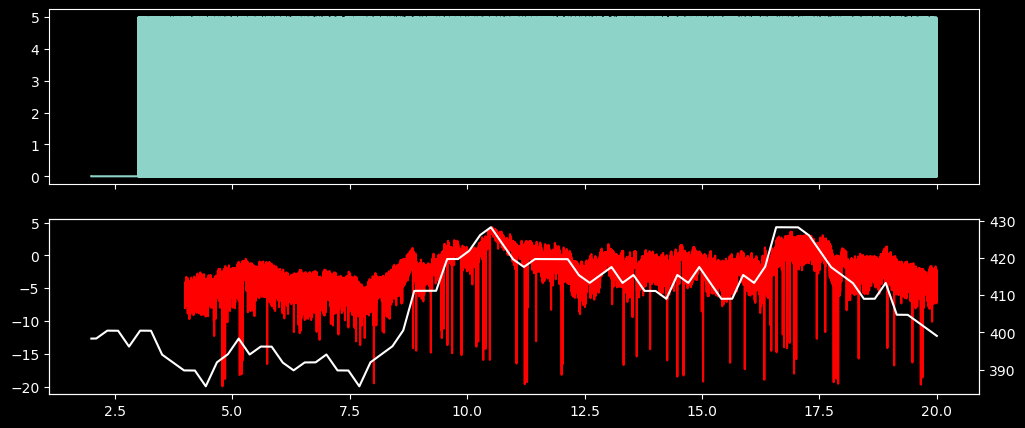

In [160]:
# get interpolated wing angles 
right_amp_interp = np.nan*np.ones_like(t)
# left_amp_interp = np.nan(t.shape)

right_amp_interp[cam_high_idx_full[-right_amp.size:]] = right_amp
nan_idx = np.isnan(right_amp_interp)
# right_amp_interp[nan_idx] = np.interp(t[nan_idx], t[~nan_idx], right_amp_interp[~nan_idx])
f_right_amp = interp1d(t[~nan_idx], right_amp_interp[~nan_idx], kind='nearest', bounds_error=False)
right_amp_interp = f_right_amp(t)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5),sharex=True)

tmin = 2
tmax = 20
mask = (t >= tmin) & (t <= tmax)

ax1.plot(t[mask], cam[mask])
ax2.plot(t[mask], right_amp_interp[mask], 'r-')
ax22 = ax2.twinx()
ax22.plot(t[mask], data['wbf'][mask], 'w-')

In [163]:
fly_frame.__dict__

{'name': 'fly frame',
 'params': {'body_axis': {'start_pt': array([318, 332]),
   'end_pt': array([194, 334])},
  'line_test': {'start_pt': array([ 80, 230]), 'end_pt': array([332, 506])},
  'left_wing': {'hinge_pt': array([324, 363]),
   'radius_inner': 80.00000000000013,
   'radius_outer': 147.05441169852773,
   'angle_hi': 2.0134889197067616,
   'angle_lo': 1.2597980461893554},
  'right_wing': {'hinge_pt': array([327, 304]),
   'radius_inner': 96.99326916178632,
   'radius_outer': 177.68511473952995,
   'angle_hi': -1.1962493546992328,
   'angle_lo': -1.7748143063874453}},
 'body_axis': <mosquito.fly_tracking_frame.MyLine at 0x739c9a263800>,
 'right_wing': <mosquito.fly_tracking_frame.MyWedge at 0x739c915e2630>,
 'left_wing': <mosquito.fly_tracking_frame.MyWedge at 0x739c915e2960>,
 'partnames': ['body_axis', 'right_wing', 'left_wing'],
 'mousing': False,
 'current_tag': None,
 'current_partname': None,
 'current_part': None,
 'image_shape': (640, 640)}

In [143]:
right_amp_interp[cam_high_idx_full[-right_amp.size:]]

array([-8.0021, -4.0639, -7.1383, ..., -7.622 , -4.4772, -2.5616])

## Can we get background?

In [15]:
# get a small stack of grayscale images
# imgs_gray = rgb2gray(imgs)
imgs_gray = []
for ith in range(imgs.shape[0]):
    imgs_gray.append(rgb2gray(imgs[ith]))

imgs_gray = np.dstack(imgs_gray)
imgs_gray = np.rollaxis(imgs_gray, 2, start=0)
imgs_gray.shape

(1000, 640, 640)

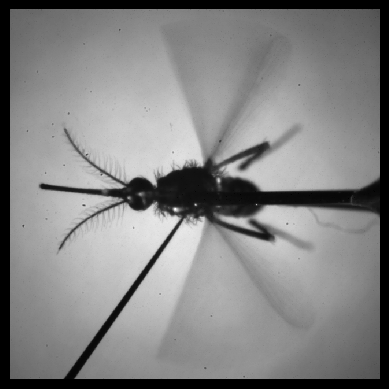

In [16]:
# get median image across a chunk
chunk_size = 20  # 35
ctr_ind = 14
bg_idx = slice(ctr_ind-int(chunk_size/2), ctr_ind+int(chunk_size/2))
bg = np.median(imgs_gray[bg_idx, :, :], axis=0)

fig, ax = plt.subplots()
ax.imshow(bg, cmap='grey', interpolation='none')
ax.set_axis_off()


## Try using ref frame for processing

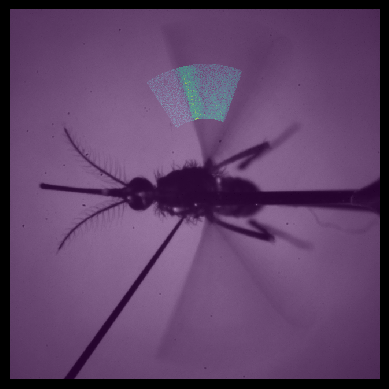

In [17]:
# look at a test image
frame_ind = 76# 182 # 15
im = imgs[frame_ind]
im_gray = rgb2gray(im)
im_gray = compare_images(im_gray, bg)

se = morphology.disk(4)
# im_gray = enhance_contrast(im_gray, se, mask=mask)  # equalize_adapthist(im_gray)
mask_dilate = morphology.isotropic_dilation(mask, 2)
im_gray = rescale_intensity(im_gray*mask_dilate)
# # im_gray = equalize_adapthist(im_gray, kernel_size=120)
# im_gray = img_as_ubyte(im_gray)

fig, ax = plt.subplots()
ax.imshow(im, cmap='grey', interpolation='none')
ax.imshow(im_gray, interpolation='none', alpha=0.5)
ax.set_axis_off()


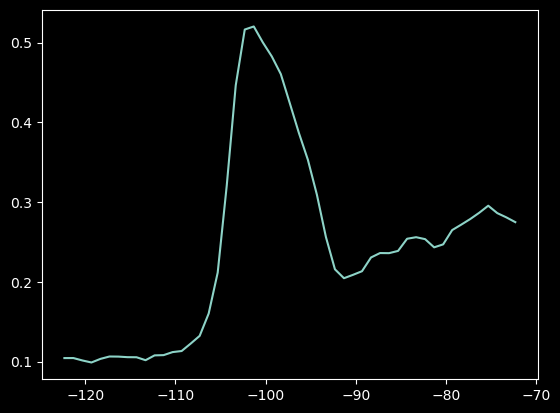

In [18]:
# test taking axial slices
angle_hi_deg = np.rad2deg(params[f'{wing_side}_wing']['angle_hi'])
angle_lo_deg = np.rad2deg(params[f'{wing_side}_wing']['angle_lo'])
angle_space_deg = np.arange(angle_lo_deg, angle_hi_deg, 1)

wedge_sums = list()

for ith in range(angle_space_deg.size - 1):
    # get mask for current angles
    angle_lo = angle_space_deg[ith]
    angle_hi = angle_space_deg[ith+1]
    x_ind, y_ind, slice_mask = get_wedge_mask(im_gray.shape, angle_hi, angle_lo, hinge_pt.astype('int'),
                                              int(radius_inner), int(radius_outer), viz_flag =False)
    
    # sum values from image in this slice
    wedge_sum = np.sum(im_gray[x_ind, y_ind])/np.sum(slice_mask)
    wedge_sums.append(wedge_sum)

    
fig, ax = plt.subplots()
angle_space_deg_ctrs = (angle_space_deg[:-1] + angle_space_deg[1:])/2.0
ax.plot(angle_space_deg_ctrs, np.asarray(wedge_sums))



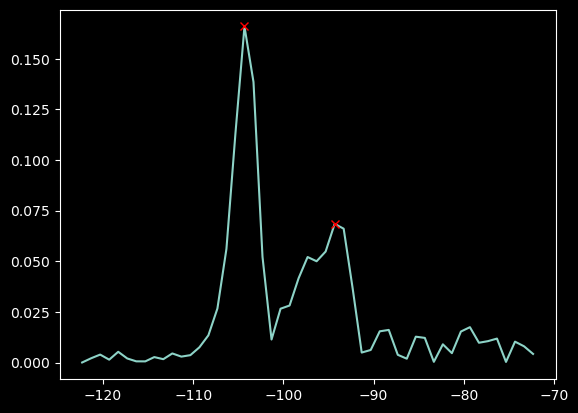

In [19]:
# do a sobel edge transformation and locate peaks
edge_1d = sobel(np.atleast_2d(wedge_sums))
edge_1d = edge_1d.ravel()

pks, _ = find_peaks(edge_1d, prominence=(0.05, None))

fig, ax = plt.subplots()
ax.plot(angle_space_deg_ctrs, edge_1d)
ax.plot(angle_space_deg_ctrs[pks], edge_1d[pks], 'rx')

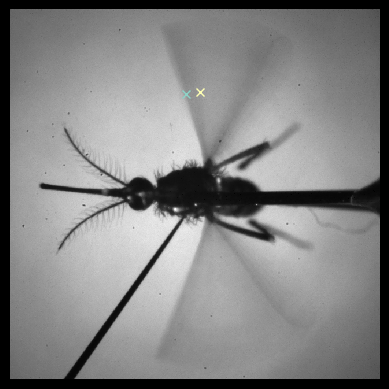

In [20]:
# which angles do peaks correspond to?
angles_deg = angle_space_deg_ctrs[pks]

fig, ax = plt.subplots()
ax.imshow(im, interpolation='none')
ax.set_axis_off()

for angle_deg in angles_deg:
    # convert to radians
    angle = np.deg2rad(angle_deg)
    
    # get coordinates of point
    pt = hinge_pt + (radius_avg * np.array([np.cos(angle), np.sin(angle)])) 

    #  draw edges on image
    ax.plot(pt[0], pt[1], 'x')


/home/sam/Documents/code/mosquito/.pixi/envs/default/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


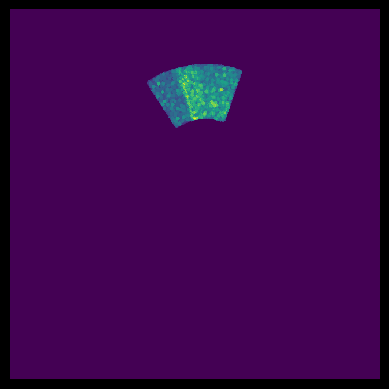

In [21]:
# try gradient calculation on left wing
se = morphology.disk(3)
gradient_image = gradient(im_gray, se, mask=mask)

fig, ax = plt.subplots()
ax.imshow(gradient_image, interpolation='none')
ax.set_axis_off()

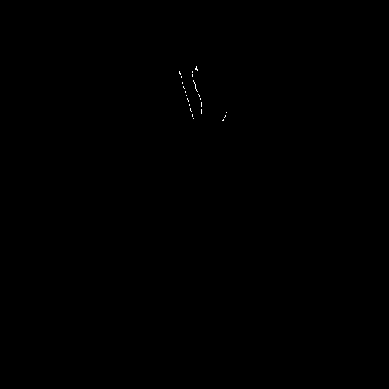

In [22]:
# maybe edge detection will work better
# edges = canny(gaussian(im_gray, sigma=0.5), sigma=3.0)  # these are values that worked well for high speed
# edges = canny(im_gray, sigma=3.5)
edges = canny(im_gray, sigma=3.5)
edges *= mask
edges = morphology.isotropic_closing(edges, 5)

fig, ax = plt.subplots()
ax.imshow(edges, cmap='grey', interpolation='none')
ax.set_axis_off()

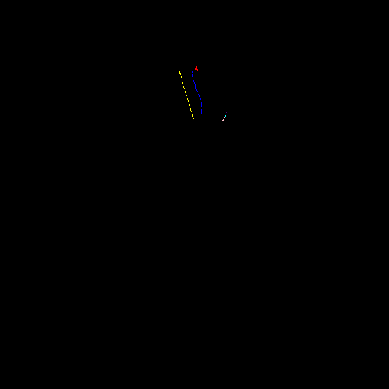

In [23]:
# what are the connected components in this edge image?
edges_label = label(edges)

fig, ax = plt.subplots()
ax.imshow(label2rgb(edges_label), interpolation='none')
ax.set_axis_off()

31.0
98.0
94.0


[-1.6617219329251833, -1.68123314880498, -1.822319399107158]

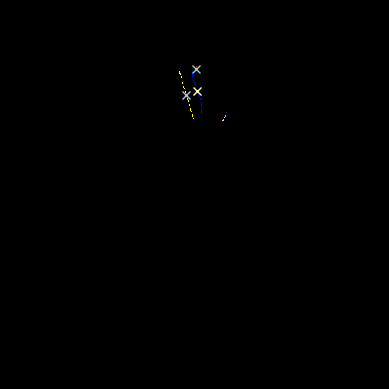

In [77]:
# get region props of connected components
props = regionprops(edges_label)
props = [p for p in props if p.area > 10]

fig, ax = plt.subplots()
ax.imshow(label2rgb(edges_label), interpolation='none')
ax.set_axis_off()

colors = ['b', 'y', 'r']

# use region props to get angle values in mask region
edge_angles = []
cc = 0
for p in props:
    cm = p.centroid
    print(p.area)
    ax.plot(cm[1], cm[0], 'x')
    # ax.plot(right_hinge[0], right_hinge[1], 'go')
    edge_angles.append(get_angle_from_points(hinge_pt, np.array([cm[1], cm[0]])))
    cc += 1
    
edge_angles

## Test cropping approach
If I stick to just ROIs, it could speed things up

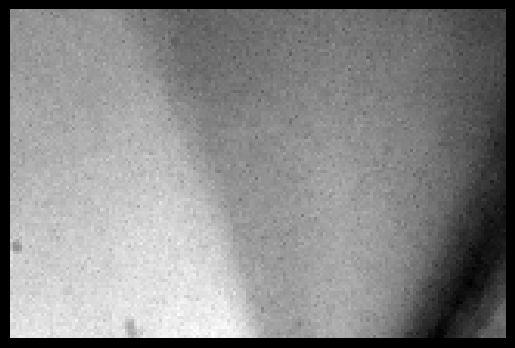

In [25]:
# clip image and do normal processing
frame_ind = 4 # 15
im = imgs[frame_ind]
im_gray = rgb2gray(im)
im_gray_clip = im_gray[roi[1]:roi[3], roi[0]:roi[2]]
mask_clip = mask[roi[1]:roi[3], roi[0]:roi[2]]

fig, ax = plt.subplots()
ax.imshow(im_gray_clip, cmap='grey', interpolation='none')
ax.set_axis_off()

In [26]:
# get edges in this image normal way and roi way
max_angle, min_angle = get_wing_edges(im_gray, mask, hinge_pt)

max_angle_roi, min_angle_roi = get_wing_edges_roi(im_gray_clip, mask_clip, hinge_pt, roi)

print('normal method max angle: ', max_angle)
print('roi method max angle: ', max_angle_roi)


No edges detected
No edges detected
normal method max angle:  None
roi method max angle:  None


## Test edge detection across frames

In [72]:
cap = ArrayVideoCapture(imgs_gray.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

# radius_inner = params['right_wing']['radius_inner']
# radius_outer = params['right_wing']['radius_outer']
# radius_avg = (radius_inner + radius_outer)/2.0
angle_max_all = list()
angle_min_all = list()
angle_max_pt_all = list()
angle_min_pt_all = list()

# get mask clipped to roi
mask_clip = mask[roi[1]:roi[3], roi[0]:roi[2]]

# # get annular wedge masks for small angle regions
# angle_hi_deg = np.rad2deg(params[f'{wing_side}_wing']['angle_hi'])
# angle_lo_deg = np.rad2deg(params[f'{wing_side}_wing']['angle_lo'])
# angle_space_deg = np.arange(angle_lo_deg, angle_hi_deg, 1)
# angle_space_deg_ctrs = (angle_space_deg[:-1] + angle_space_deg[1:])/2.0
# angle_space_ctrs = np.deg2rad(angle_space_deg_ctrs)

# wedge_masks_clip = list()
# for ith in range(angle_space_deg.size - 1):
#     # get mask for current angles
#     angle_lo = angle_space_deg[ith]
#     angle_hi = angle_space_deg[ith+1]
#     _, _, wedge_mask = get_wedge_mask(imgs_gray.shape[:2], angle_hi, angle_lo, hinge_pt.astype('int'), 
#                                       int(radius_inner), int(radius_outer), viz_flag =False)
    
#     wedge_masks_clip.append(wedge_mask[roi[1]:roi[3], roi[0]:roi[2]])
    
#     # # sum values from image in this slice
#     # wedge_sum = np.sum(im_gray[x_ind, y_ind])/np.sum(slice_mask)
#     # wedge_sums.append(wedge_sum)

# start a counter
cc = 0
bg_window = 10  # 17

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break
    
    # process image
    if len(frame.shape) > 2:
        im_gray = rgb2gray(frame)
    else:
        im_gray = frame

    # clip image
    im_gray_clip = im_gray[roi[1]:roi[3], roi[0]:roi[2]]
    
    # do background subtraction (?)
    idx1 = max([cc - bg_window, 0])
    idx2 = min([cc + bg_window, imgs.shape[0]])
    bg = np.median(imgs_gray[idx1:idx2, roi[1]:roi[3], roi[0]:roi[2]], axis=0)
    
    im_bg_sub = compare_images(im_gray_clip, bg)
    
    # get edges
    # angle_max, angle_min = get_wing_edges(im_bg_sub, mask, hinge_pt)
    angle_max, angle_min = get_wing_edges_roi(im_bg_sub, mask_clip, hinge_pt, roi)
    # angle_max, angle_min = get_wing_edges_wedge_sum(im_bg_sub, wedge_masks_clip, angle_space_ctrs)

    # get coordinate points for edges (for display) and store values
    if angle_max is not None:
        # calculate point
        angle_max_pt = hinge_pt + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 

        # draw circle
        cv2.circle(frame, angle_max_pt.astype('int'), 4, (255, 0, 0, 255), -1)
        
        # store
        angle_max_all.append(angle_max)
        angle_max_pt_all.append(angle_max_pt)
        
    else:
        angle_max_all.append(np.nan)
        print(cc)
        
    if angle_min is not None:
        # calculate point
        angle_min_pt = hinge_pt + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  

        # draw edges on image
        cv2.circle(frame, angle_min_pt.astype('int'), 4, (0, 0, 255, 255), -1)
    
        # store values
        angle_min_all.append(angle_min)          
        angle_min_pt_all.append(angle_min_pt)
        
    else:
        angle_min_all.append(np.nan)
        
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(25) & 0xFF
    if k == 27:
        break

    # increment counter
    cc += 1

cv2.destroyAllWindows()
cap.release()


No edges detected
44
No edges detected
46
No edges detected
172
No edges detected
173
No edges detected
174
No edges detected
175
No edges detected
177
No edges detected
178
No edges detected
297
No edges detected
336
No edges detected
402
No edges detected
403
No edges detected
497
No edges detected
498
No edges detected
560
No edges detected
628
No edges detected
630
No edges detected
632
No edges detected
730
No edges detected
734
No edges detected
839
No edges detected
840
No edges detected
841
No edges detected
885
No edges detected
889
No edges detected
891
No edges detected
893
No edges detected
960
No edges detected
962
No edges detected
993


In [80]:
fly_frame.__dict__

{'name': 'fly frame',
 'params': {'body_axis': {'start_pt': array([341, 315]),
   'end_pt': array([196, 319])},
  'line_test': {'start_pt': array([ 80, 230]), 'end_pt': array([332, 506])},
  'left_wing': {'hinge_pt': array([345, 355]),
   'radius_inner': 80.00000000000006,
   'radius_outer': 157.42934923323565,
   'angle_hi': 2.1391550920340863,
   'angle_lo': 1.0957855705297999},
  'right_wing': {'hinge_pt': array([338, 278]),
   'radius_inner': 91.78573738411428,
   'radius_outer': 180.85353189805298,
   'angle_hi': -1.2469493394108548,
   'angle_lo': -2.1434627095007346}},
 'body_axis': <mosquito.fly_tracking_frame.MyLine at 0x715a2fd24800>,
 'right_wing': <mosquito.fly_tracking_frame.MyWedge at 0x715aa47321b0>,
 'left_wing': <mosquito.fly_tracking_frame.MyWedge at 0x715aad25fc20>,
 'partnames': ['body_axis', 'right_wing', 'left_wing'],
 'mousing': False,
 'current_tag': None,
 'current_partname': None,
 'current_part': None,
 'image_shape': (640, 640)}

In [54]:
# wedge_sums = []
# for wmask in wedge_masks_clip:
#     # do normalized sum
#     wedge_sum = np.sum(im_bg_sub*wmask)/np.sum(wmask)
#     wedge_sums.append(wedge_sum)

# plt.plot(wedge_sums)

In [55]:
# # detect edges in this "1D image"
# edge_1d = sobel(np.atleast_2d(wedge_sums))
# edge_1d = edge_1d.ravel()

# plt.plot(edge_1d)

In [56]:
# # find peaks in the edge detection
# pks, _ = find_peaks(edge_1d, prominence=(0.001, None))
# pks

(-2.0, -1.6)

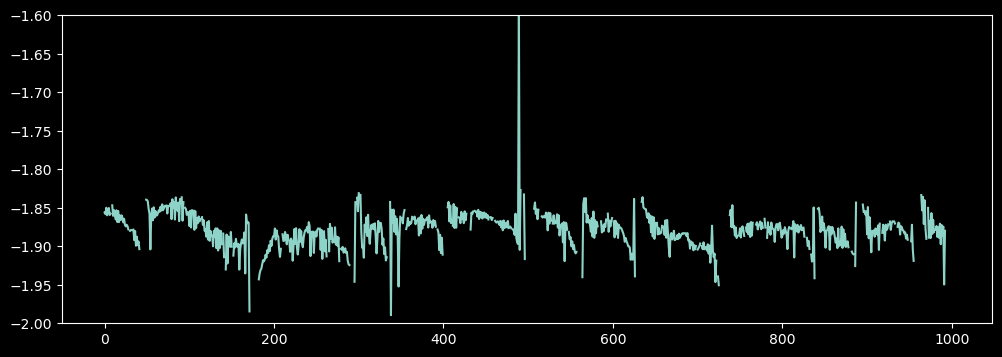

In [74]:
# see what the extracted angle looks like
# angle_roi = np.asarray(angle_min_all)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(1000), angle_roi)
ax.set_ylim([-2, -1.6])

(-2.0, -1.6)

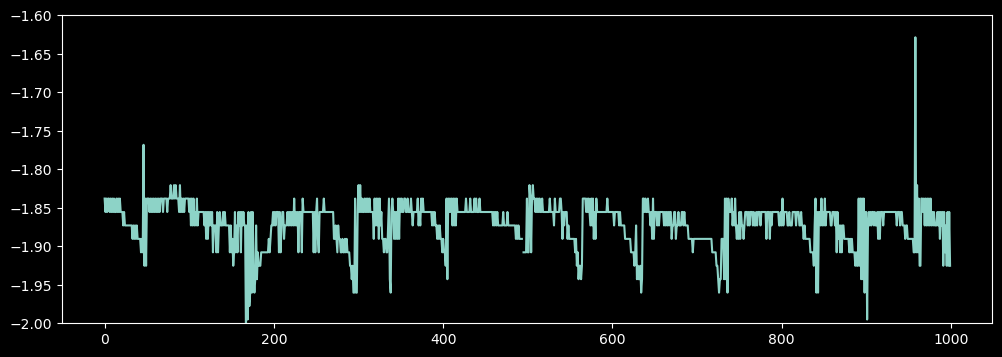

In [75]:
# see what the extracted angle looks like
# angle_wedge = np.asarray(angle_min_all)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.arange(1000), angle_wedge)
ax.set_ylim([-2, -1.6])

(0.0, 40.0)

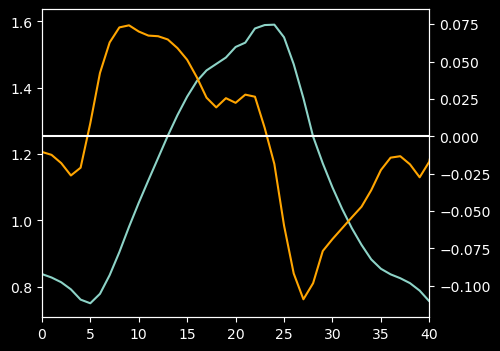

In [172]:
# get estimate of wing center of mass (at least in polar angle coordinates) to distinguish between leading and trailing edges
wing_cm_angles = (np.asarray(angle_max_all) + np.asarray(angle_min_all))/2.0

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(wing_cm_angles)

ax1 = ax.twinx()
ax1.plot(np.gradient(wing_cm_angles), color='orange')
ax1.axhline(0, color='w')
ax.set_xlim([0, 40])

(0.0, 40.0)

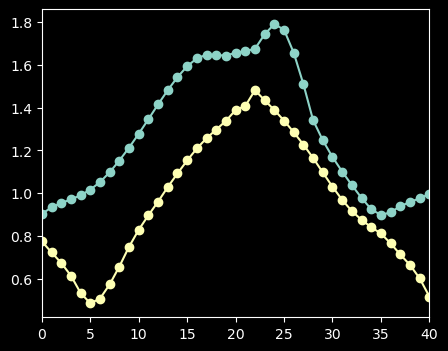

In [169]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(angle_max_all, 'o-')
ax.plot(angle_min_all, 'o-')

ax.set_xlim([0, 40])

In [178]:
# for first pass, just use simple velocity sign to make assignment
cap = ArrayVideoCapture(imgs.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

wing_cm_vel = np.gradient(wing_cm_angles)
cc = 0

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edge angles
    angle_max = angle_max_all[cc]
    angle_min = angle_min_all[cc]

    # get coordinate points for edges (for display)
    angle_max_pt = right_hinge + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 
    angle_min_pt = right_hinge + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  

    # leading_edge = angle_max_pt
    # trailing_edge = angle_min_pt
  
    if wing_cm_vel[cc] >= 0:
        leading_edge = angle_max_pt
        trailing_edge = angle_min_pt
    else:
        leading_edge = angle_min_pt
        trailing_edge = angle_max_pt
        
    # draw edges on image
    cv2.circle(frame, leading_edge.astype('int'), 4, (255, 0, 0, 255), -1)
    cv2.circle(frame, trailing_edge.astype('int'), 4, (0, 0, 255, 255), -1)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(0) & 0xFF
    if k == 27:
        break
    
    cc += 1
    
cv2.destroyAllWindows()
cap.release()


(355, 430)
(359, 429)
(359, 429)
(356, 432)


In [188]:
# # Use manual clicking to assign leading vs trailing edge
# cap = ArrayVideoCapture(imgs.copy())
# window_name = 'edge detection'
# cv2.namedWindow(window_name)

# leading_edge_all = list()
# trailing_edge_all = list()

# cc = 0

# while True:
#     # read next frame
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # get edge angles
#     angle_max = angle_max_all[cc]
#     angle_min = angle_min_all[cc]

#     # get coordinate points for edges (for display)
#     angle_max_pt = right_hinge + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 
#     angle_min_pt = right_hinge + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  
        
#     # draw edges on image
#     cv2.circle(frame, angle_max_pt.astype('int'), 4, (255, 0, 0, 255), -1)
#     cv2.circle(frame, angle_min_pt.astype('int'), 4, (0, 0, 255, 255), -1)
    
#     # show image
#     cv2.imshow(window_name, frame)
#     cv2.setMouseCallback(window_name, get_xy)
    
#     # playback options
#     k = cv2.waitKey(0) & 0xFF
#     if k == 27:
#         break

#     # we're clicking on leading edge, so find closest point and store
#     pts = np.vstack([angle_max_pt, angle_min_pt])
#     dist = np.linalg.norm(pts - np.array([mouseX, mouseY]), axis=1)
#     sort_ind = np.argsort(dist) 
#     leading_edge_all.append(pts[sort_ind[0]])
#     trailing_edge_all.append(pts[sort_ind[1]])
    
#     # increment counter
#     cc += 1
    
# cv2.destroyAllWindows()
# cap.release()


(0.0, 40.0)

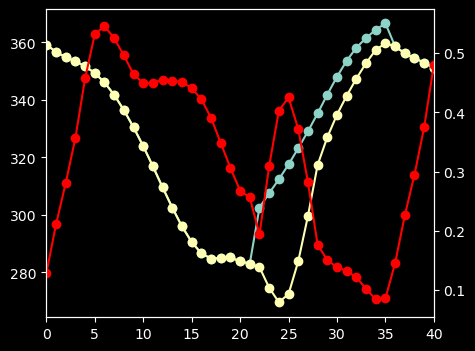

In [228]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(np.asarray(leading_edge_all)[:,0], 'o-')
ax.plot(np.asarray(angle_max_pts_all)[:,0], 'o-')
# ax.plot(np.asarray(wing_cm_angles), 'o-')

ax1 = ax.twinx()
ax1.plot(np.asarray(angle_max_all) - np.asarray(angle_min_all), 'o-', color='red')

ax.set_xlim([0, 40])



(0.0, 40.0)

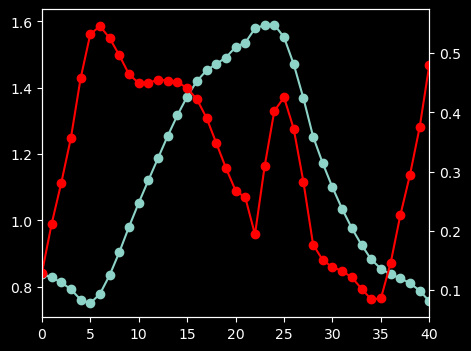

In [231]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(wing_cm_angles, 'o-')

ax1 = ax.twinx()
ax1.plot(np.asarray(angle_max_all) - np.asarray(angle_min_all), 'o-', color='red')

ax.set_xlim([0, 40])

It seems like switches between min/max angles for leading/trailing correspond (roughly) to minima in the difference between max and min wing angles over time

(0.0, 120.0)

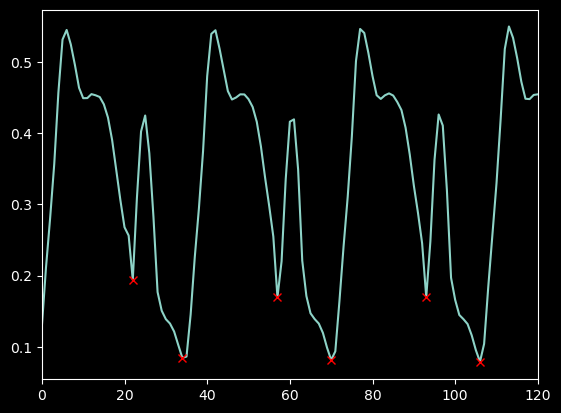

In [241]:
# find such minima
wing_angle_diff = np.asarray(angle_max_all) - np.asarray(angle_min_all)
t_samp = np.arange(wing_angle_diff.size)

pks, props = find_peaks(-1*wing_angle_diff, prominence=(0.1, None))

fig, ax = plt.subplots()

ax.plot(t_samp, wing_angle_diff)
ax.plot(t_samp[pks], wing_angle_diff[pks], 'rx')

ax.set_xlim([0, 120])


In [254]:
# get average velocity between these points
chunk_idx = [np.sum(t >= pks) for t in t_samp]
chunk_idx = np.asarray(chunk_idx)

leading_edge_all = []
trailing_edge_all = []

angle_max_arr = np.asarray(angle_max_all)
angle_min_arr = np.asarray(angle_min_all)

for chunk in np.unique(chunk_idx):
    idx = (chunk_idx == chunk)
    vel_mean = np.mean(wing_cm_vel[idx])

    if vel_mean < 0:
        leading_edge = angle_min_arr[idx]
        trailing_edge = angle_max_arr[idx]
    else:
        leading_edge = angle_max_arr[idx]
        trailing_edge = angle_min_arr[idx]
        
    leading_edge_all.extend(leading_edge)
    trailing_edge_all.extend(trailing_edge)
    


In [255]:
# try with heuristic applied
cap = ArrayVideoCapture(imgs.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

wing_cm_vel = np.gradient(wing_cm_angles)
cc = 0

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edge angles
    leading_edge_ang = leading_edge_all[cc]
    trailing_edge_ang = trailing_edge_all[cc]

    # get coordinate points for edges (for display)
    leading_edge = right_hinge + (radius_avg * np.array([np.cos(leading_edge_ang), np.sin(leading_edge_ang)])) 
    trailing_edge = right_hinge + (radius_avg * np.array([np.cos(trailing_edge_ang), np.sin(trailing_edge_ang )]))  

    # draw edges on image
    cv2.circle(frame, leading_edge.astype('int'), 4, (255, 0, 0, 255), -1)
    cv2.circle(frame, trailing_edge.astype('int'), 4, (0, 0, 255, 255), -1)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(0) & 0xFF
    if k == 27:
        break
    
    cc += 1
    
cv2.destroyAllWindows()
cap.release()


## Version with OpenCV

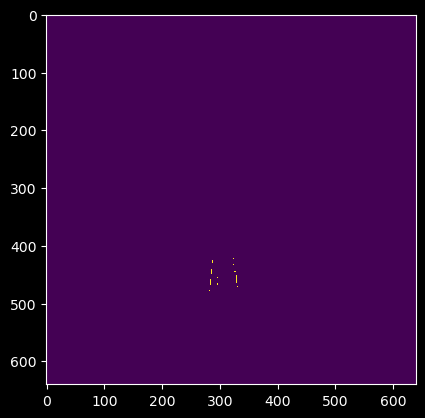

In [126]:
# Let's try the same in opencv
blur = cv2.GaussianBlur(im_gray, (9, 9), 0)
# blur = cv2.bilateralFilter(im_gray, 5, 
edges = cv2.Canny(blur, 100, 100)
edges *= right_mask

plt.imshow(edges, interpolation='none')

In [127]:
# get connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges)

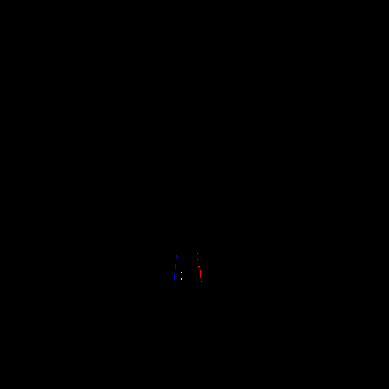

In [128]:
fig, ax = plt.subplots()
ax.imshow(label2rgb(labels), interpolation='none')
ax.set_axis_off()

In [129]:
num_labels

4

In [39]:
# # trying hough transform to extract edges -- doesn't work!
# # Step 1: Edge Detection
# edges = canny(im_gray, sigma=1.0)
# edges *= right_mask

# # Step 2: Hough Transform
# hough_space, angles, distances = hough_line(edges)

# # Step 2.5: display image
# fig, ax = plt.subplots()
# ax.imshow(edges)
# ax.set_axis_off()

# # # Step 3: Extracting Lines
# for _, angle, dist in zip(*hough_line_peaks(hough_space, angles, distances)):
#     (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
#     ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color='red')

